In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using PhasorNetworks

In [3]:
using Plots

In [4]:
using LinearAlgebra: triu, diagm, diag

In [5]:
using Statistics: std, median

In [6]:
using QuadGK

In [7]:
using Random: Xoshiro, AbstractRNG

# Construct a random graph

In [8]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [9]:
function generate_er_graph(n::Int, p::Real, rng::AbstractRNG, self_loops::Bool = false)
    adj = rand(rng, Float64, (n, n)) .< p
    #make undirected
    adj = triu(adj)
    adj =  (adj .+ adj') .> 0

    if !self_loops
        #remove self-loops
        for i in 1:n
            adj[i,i] = 0
        end
    end

    return adj
end

generate_er_graph (generic function with 2 methods)

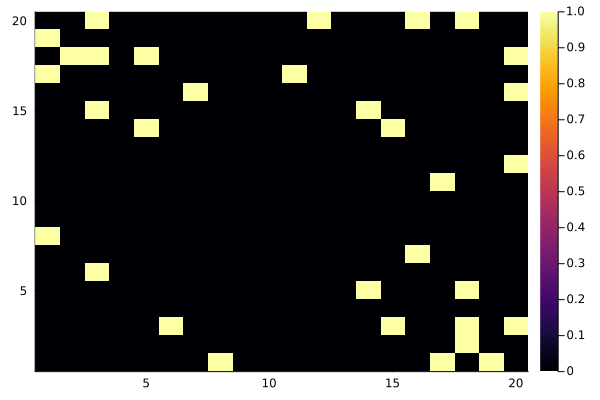

In [10]:
g1 = generate_er_graph(20, 0.1, rng)
heatmap(g1)

# Embed it into an HD vector

In [11]:
function define_node_symbols(graph::AbstractMatrix, nd::Int, rng::AbstractRNG)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)

    #create vectors representing the nodes
    node_values = random_symbols((n, nd), rng)
    return node_values
end

define_node_symbols (generic function with 1 method)

In [12]:
nv1 = define_node_symbols(g1, 1024, rng);

In [13]:
size(nv1)

(20, 1024)

In [14]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    nd = size(node_values, 2)

    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = zeros(Float64, n_edges, nd)

    #iterate through the edges
    for (i, edge) in enumerate(edges)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = node_values[tx,:]
        rx_symbol = node_values[rx,:]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = v_bind(tx_symbol, rx_symbol)
        edge_values[i,:] = edge_symbol
    end

    #DEBUG
    return edge_values
    #combine the edges in the graph to the single embedding via bundling
    graph_embedding = v_bundle(edge_values, dims=1)
    return graph_embedding
end

graph_to_vector (generic function with 1 method)

In [15]:
ev1 = graph_to_vector(g1, nv1)
#gv1 = graph_to_vector(g1, nv1)

32×1024 Matrix{Float64}:
  0.282414   -0.378837   -0.0656762  …  -0.856107    0.313519    0.578887
  0.567928    0.865157   -0.0365864     -0.122379   -0.0655621  -0.238822
  0.51084    -0.628985   -0.642356      -0.572502   -0.281497   -0.790776
 -0.0968375  -0.815286   -0.397687      -0.0667605  -0.131531   -0.721839
 -0.439756    0.245632    0.957151      -0.279293   -0.506596    0.993515
 -0.949453   -0.660928   -0.932076   …  -0.92339    -0.921685    0.677349
  0.417221   -0.778585    0.150208       0.643981   -0.835362    0.550087
  0.944189    0.960663    0.0697639      0.752973   -0.466694    0.0528262
 -0.322538   -0.0940363   0.838584      -0.189911   -0.0832154   0.705601
 -0.774898    0.740316   -0.0232253     -0.655109    0.132253   -0.216317
 -0.439756    0.245632    0.957151   …  -0.279293   -0.506596    0.993515
  0.73021    -0.206266   -0.0492315      0.140217    0.777843    0.488207
  0.282414   -0.378837   -0.0656762     -0.856107    0.313519    0.578887
  ⋮         

In [16]:
sa = SpikingArgs(threshold=0.0001)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.0001 (V)


In [17]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix, spk_args::SpikingArgs; repeats::Int=5)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    nd = size(node_values, 2)
    
    #slice each node symbol into a spike train
    train_values = [phase_to_train(reshape(node, (1,:)), spk_args, repeats=repeats) for node in eachslice(node_values, dims=1)]
    tspan = (0.0, repeats * 1.0)
    
    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = []

    #iterate through the edges
    function edge_to_train(edge)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = train_values[tx]
        rx_symbol = train_values[rx]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = v_bind(tx_symbol, rx_symbol, spk_args=spk_args, tspan=tspan)
        return edge_symbol
    end

    edge_values = map(edge_to_train, edges)
    #combine the edges in the graph to the single embedding via bundling
    #DEBUG 
    return train_values, edge_values
    combined = vcat_trains(edge_values)
    graph_embedding = v_bundle(combined, dims=1, spk_args=spk_args, tspan=tspan)
    return train_values, graph_embedding, tspan
end

graph_to_vector (generic function with 2 methods)

In [27]:
tv1, evt1 = graph_to_vector(g1, nv1, sa, repeats=5)
#nvt1, gvt1, tspan = graph_to_vector(g1, nv1, sa, repeats=5)

(SpikeTrain[Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes.], SpikeTrain[Spike Train: (1, 1024) with 2595 spikes., Spike Train: (1, 1024) with 2481 spikes., Spike Train: (1, 1024) with 2547 spikes., Spike Trai

In [19]:
p1 = train_to_phase(tv1[1], sa);

In [20]:
e1 = map(x -> x .- nv1[1:1,:], eachslice(p1, dims=1));

In [21]:
using Base.Iterators: flatten

In [22]:
sum(collect(flatten(e1)))

0.0

In [23]:
#no error in encoding nodes into spikes

In [24]:
cx = findall(g1);

In [28]:
edgeval = v_bind(tv1[cx[1][1]], tv1[cx[1][2]], spk_args=sa, tspan=(0.0, 5.0))

Spike Train: (1, 1024) with 2595 spikes.

In [34]:
edgeval2 = train_to_phase(edgeval, sa)

6×1×1024 Array{Float64, 3}:
[:, :, 1] =
 NaN
   0.2825722492731413
   0.28257061952775686
   0.2825692885038711
   0.28256816197515455
   0.2825669654604219

[:, :, 2] =
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

[:, :, 3] =
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

;;; … 

[:, :, 1022] =
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

[:, :, 1023] =
 NaN
   0.31367813905044173
   0.3136762668297921
   0.31367494891090253
   0.3136742239988539
   0.31367293250051986

[:, :, 1024] =
 NaN
   0.5790455707572963
   0.579044252459159
   0.5790431542713641
   0.5790413816150064
   0.5790405164119861

In [35]:
edgeval_soln = v_bind(tv1[cx[1][1]], tv1[cx[1][2]], spk_args=sa, tspan=(0.0, 5.0), return_solution=true)

#57 (generic function with 1 method)

In [44]:
tsteps = 0.0:0.01:5.01 |> collect;

In [53]:
edgeval_u = stack(edgeval_soln.(tsteps));

In [65]:
edgeval_up = solution_to_phase(edgeval_soln, tsteps, spk_args=sa);

In [66]:
edgeval_up  |> size

(1, 1024, 502)

In [71]:
using Statistics: mean

In [74]:
temp_error = [mean(edgeval_up[1,:,i] .- ev1[1,:]) for i in axes(edgeval_up, 3)];

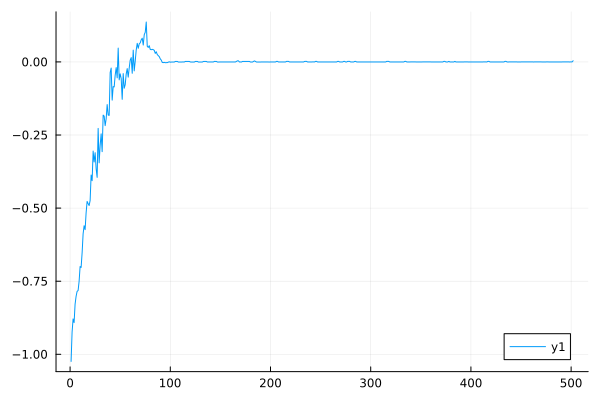

In [75]:
plot(temp_error)

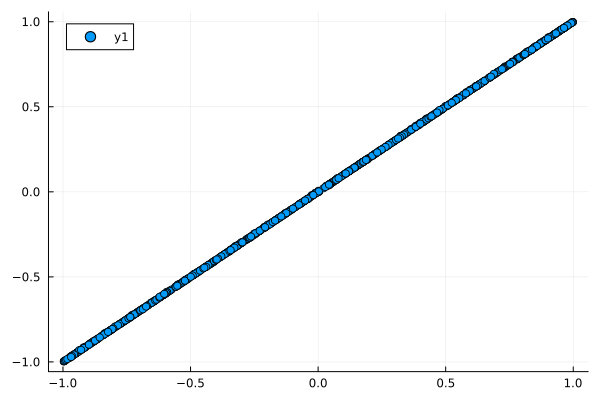

In [69]:
scatter(edgeval_up[1,:,256], ev1[1,:])

In [70]:
#encoding into potentials is ok

In [ ]:
#problem is with solution to train

In [99]:
using DifferentialEquations: ODESolution

In [109]:
import PhasorNetworks: solution_to_train, generate_cycles, phase_to_time, spiking_offset

In [110]:
function solution_to_train(sol::Union{ODESolution,Function}, tspan::Tuple{<:Real, <:Real}; spk_args::SpikingArgs, offset::Real)
    #determine the ending time of each cycle
    cycles = generate_cycles(tspan, spk_args, offset)
    #sample the potential at the end of each cycle
    u = solution_to_potential(sol, cycles)
    spiking = abs.(u) .> spk_args.threshold
    
    #convert the phase represented by that potential to a spike time
    p = potential_to_phase(u, cycles, dim=ndims(u), offset=offset, spk_args=spk_args)
    t = phase_to_time(p, offset, spk_args = spk_args)
    nd = ndims(t)
    shift = x -> permutedims(x, (nd, 1:(nd-1)...))
    unshift = x -> permutedims(x, (2:nd..., 1))
    t = unshift(shift(t) .+ cycles)

    #return only the times where the neuron is spiking
    cut_index = i -> CartesianIndex(Tuple(i)[1:end-1])
    inds = findall(spiking)
    tms = t[inds] .+ spiking_offset(spk_args)
    
    inds = cut_index.(inds)
    train = SpikeTrain(inds, tms, size(u)[1:end-1], offset + spiking_offset(spk_args))
    return train
end

solution_to_train (generic function with 1 method)

In [111]:
cycles = generate_cycles((0.0, 5.0), sa, 0.0)

5-element Vector{Float64}:
 1.0
 2.0
 3.0
 4.0
 5.0

In [112]:
usamples = solution_to_potential(edgeval_soln, cycles)

1×1024×5 Array{ComplexF64, 3}:
[:, :, 1] =
 -0.00066274+0.000814426im  …  0.000265841+0.00104842im

[:, :, 2] =
 -0.00219221+0.00269393im  …  0.00087933+0.00346796im

[:, :, 3] =
 -0.00410597+0.00504563im  …  0.00164693+0.00649538im

[:, :, 4] =
 -0.00611625+0.00751593im  -0.00337376-0.0084192im  …  0.00245321+0.0096755im

[:, :, 5] =
 -0.00805938+0.00990366im  -0.00444556-0.0110939im  …  0.00323254+0.0127493im

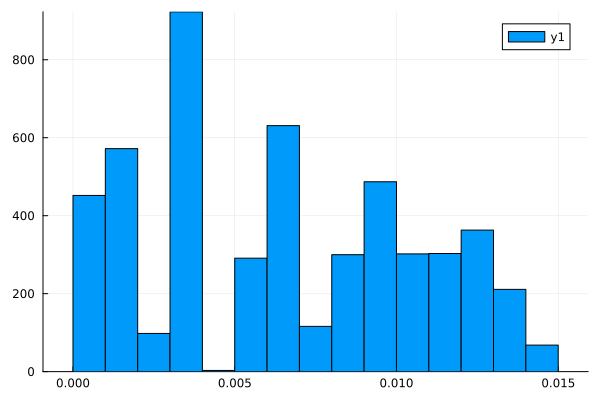

In [113]:
histogram(vec(abs.(usamples)))

In [114]:
st = solution_to_train(edgeval_soln, (0.0, 5.0), spk_args = sa, offset = 0.0)

Spike Train: (1, 1024) with 5120 spikes.

In [115]:
stp = train_to_phase(st, sa);

In [116]:
sum(isnan.(stp))

1024

In [127]:
err2 = [(ev1[1,:] - stp[i,1,:]) for i in axes(stp,1)]

6-element Vector{Vector{Float64}}:
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [-0.00015852818854655837, -0.0001579984854114258, -0.00015834059052721727, -0.00015740024299359945, -0.00015908048959367704, -0.0001579528808659525, -0.0001583656352788232, 0.0016429416318617385, -0.00015943695593811924, -0.00015731597396806407  …  -0.00015902129230482842, -0.00015921862722922953, -0.00015814307778505565, -0.00015869400475310158, -0.00015956596148392066, -0.0001580784991581652, -0.00015935048122361906, -0.00015791142314647288, -0.00015878041549299837, -0.00015858497848775244]
 [-0.00015689844316213453, -0.00015656686794596197, -0.000156893268204783, -0.00015544236028830483, -0.00015744264126382745, -0.00015654630346961795, -0.00015686090017830168, 0.0016442556805751352, -0.0001579281283401457, -0.00015594745648428443  …  -0.00015756514355036444, -0.00015791439128509666, -0.0001566765548171034, -0.0001570925932217193, -0.0001581758

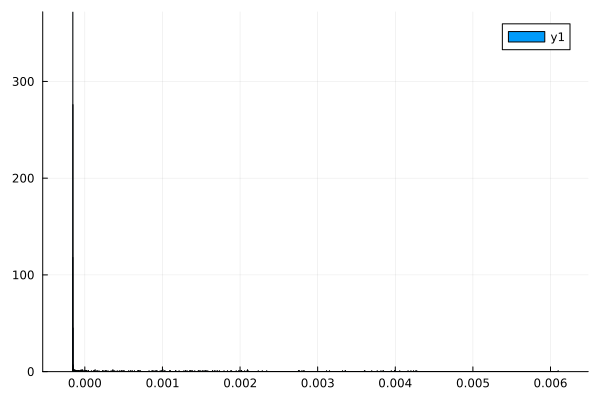

In [129]:
histogram(vec(err2[end-1]))

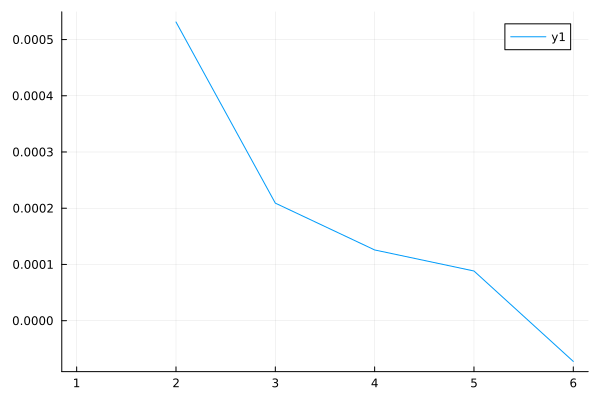

In [130]:
plot(collect(flatten(map(mean, err2))))

In [79]:
st

Spike Train: (1, 1024) with 2595 spikes.

In [55]:
size(edgeval_u)

(1, 1024, 502)

In [61]:
edgeval_nans = findall(isnan.(edgeval2))

3549-element Vector{CartesianIndex{3}}:
 CartesianIndex(1, 1, 1)
 CartesianIndex(1, 1, 2)
 CartesianIndex(2, 1, 2)
 CartesianIndex(3, 1, 2)
 CartesianIndex(4, 1, 2)
 CartesianIndex(5, 1, 2)
 CartesianIndex(6, 1, 2)
 CartesianIndex(1, 1, 3)
 CartesianIndex(2, 1, 3)
 CartesianIndex(3, 1, 3)
 CartesianIndex(4, 1, 3)
 CartesianIndex(5, 1, 3)
 CartesianIndex(6, 1, 3)
 ⋮
 CartesianIndex(3, 1, 1021)
 CartesianIndex(4, 1, 1021)
 CartesianIndex(5, 1, 1021)
 CartesianIndex(6, 1, 1021)
 CartesianIndex(1, 1, 1022)
 CartesianIndex(2, 1, 1022)
 CartesianIndex(3, 1, 1022)
 CartesianIndex(4, 1, 1022)
 CartesianIndex(5, 1, 1022)
 CartesianIndex(6, 1, 1022)
 CartesianIndex(1, 1, 1023)
 CartesianIndex(1, 1, 1024)

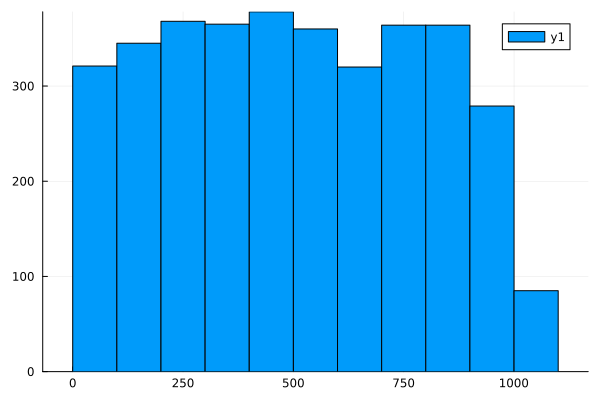

In [63]:
histogram(getindex.(edgeval_nans, 3))

In [56]:
function plotind(i)
    plot(real.(edgeval_u[1,i,:]))
    plot!(imag.(edgeval_u[1,i,:]))
end

plotind (generic function with 1 method)

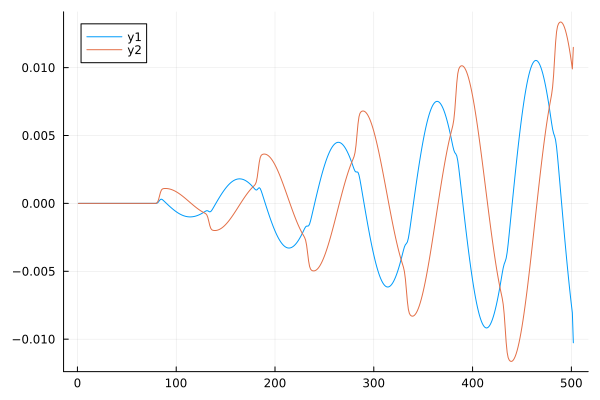

In [57]:
plotind(1)

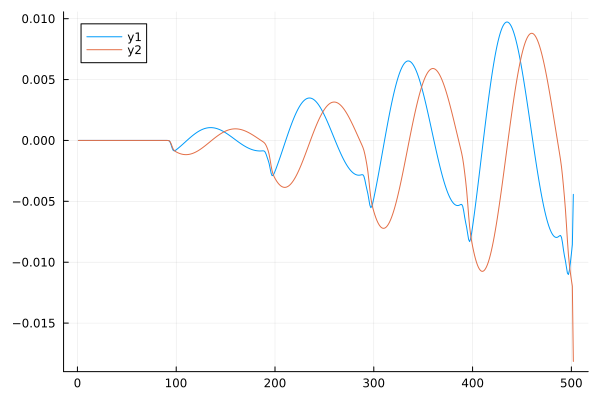

In [58]:
plotind(512)

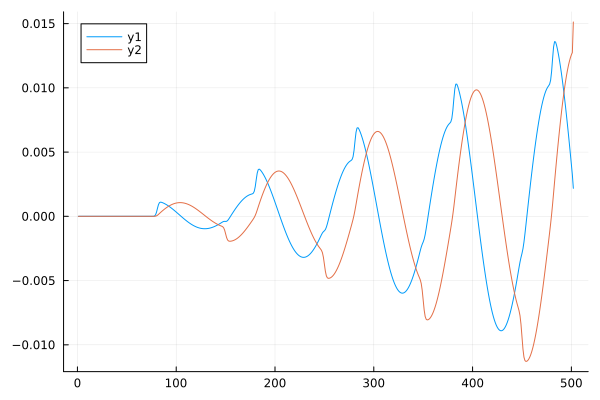

In [59]:
plotind(1024)

In [84]:
evt1

32-element Vector{SpikeTrain}:
 Spike Train: (1, 1024) with 2595 spikes.
 Spike Train: (1, 1024) with 2481 spikes.
 Spike Train: (1, 1024) with 2547 spikes.
 Spike Train: (1, 1024) with 2409 spikes.
 Spike Train: (1, 1024) with 2648 spikes.
 Spike Train: (1, 1024) with 2529 spikes.
 Spike Train: (1, 1024) with 2330 spikes.
 Spike Train: (1, 1024) with 2531 spikes.
 Spike Train: (1, 1024) with 2573 spikes.
 Spike Train: (1, 1024) with 2490 spikes.
 Spike Train: (1, 1024) with 2648 spikes.
 Spike Train: (1, 1024) with 2542 spikes.
 Spike Train: (1, 1024) with 2595 spikes.
 ⋮
 Spike Train: (1, 1024) with 2587 spikes.
 Spike Train: (1, 1024) with 2481 spikes.
 Spike Train: (1, 1024) with 2596 spikes.
 Spike Train: (1, 1024) with 2409 spikes.
 Spike Train: (1, 1024) with 2330 spikes.
 Spike Train: (1, 1024) with 2490 spikes.
 Spike Train: (1, 1024) with 2508 spikes.
 Spike Train: (1, 1024) with 2547 spikes.
 Spike Train: (1, 1024) with 2531 spikes.
 Spike Train: (1, 1024) with 2541 spikes.


In [85]:
evt1p = map(x -> train_to_phase(x, sa), evt1)

32-element Vector{Array{Float64, 3}}:
 [NaN; 0.2825722492731413; … ; 0.28256816197515455; 0.2825669654604219;;; NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN;;; … ;;; NaN; NaN; … ; NaN; NaN;;; NaN; 0.31367813905044173; … ; 0.3136742239988539; 0.31367293250051986;;; NaN; 0.5790455707572963; … ; 0.5790413816150064; 0.5790405164119861]
 [NaN; 0.5680873434116194; … ; 0.5680834486242965; 0.5680822580783662;;; NaN; 0.8653166276068394; … ; 0.865312248730497; 0.8653111552823951;;; NaN; NaN; … ; NaN; NaN;;; … ;;; NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN]
 [NaN; 0.5109984751674634; … ; 0.5109950021801382; 0.5109939715534715;;; NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN;;; … ;;; NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN]
 [NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN;;; … ;;; NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN;;; NaN; NaN; … ; NaN; NaN]
 [NaN; NaN; … ; NaN; NaN;;; NaN; 0.2457907

In [86]:
mapslices(x -> sum(isnan.(x)), evt1p[1], dims=(2,3))

6×1×1 Array{Int64, 3}:
[:, :, 1] =
 1024
  519
  507
  502
  499
  498

In [32]:
#why so many NaNs?

In [ ]:
stop

In [26]:
c = graph_to_vector(g1, nv1, sa, repeats=5)

(SpikeTrain[Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes.], Spike Train: (1, 1024) with 1554 spikes., (0.0, 5.0))

In [27]:
pc = train_to_phase(, sa);

LoadError: MethodError: no method matching train_to_phase(::Tuple{Vector{SpikeTrain}, SpikeTrain, Tuple{Float64, Float64}}, ::SpikingArgs)

[0mClosest candidates are:
[0m  train_to_phase([91m::SpikeTrain[39m, ::SpikingArgs)
[0m[90m   @[39m [36mPhasorNetworks[39m [90m~/.julia/packages/PhasorNetworks/aUVbH/src/[39m[90m[4mspiking.jl:394[24m[39m


In [28]:
pc[4,:,:]

LoadError: UndefVarError: `pc` not defined

In [29]:
phases = train_to_phase(gvt1, sa);

In [30]:
size(phases)

(6, 1, 1024)

In [31]:
ss = similarity(gv1, zero_nans(phases[end-1,1:1,:]), dim=1)

1×1024 Matrix{Float64}:
 -0.842892  -0.901022  0.922641  …  -0.00831339  0.982932  -0.832075

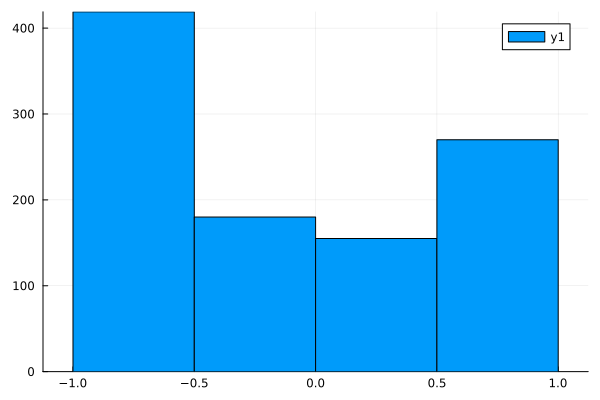

In [32]:
histogram(ss |> vec)

In [26]:
median(ss)

-0.06651201159604642

# Use similarity to reconstruct the graph

In [23]:
function query_edges(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 1 method)

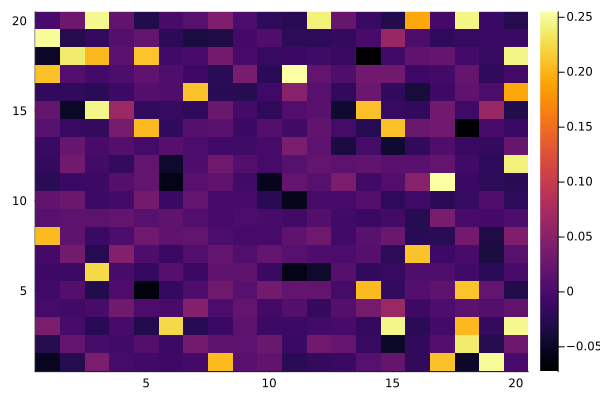

In [24]:
rec1 = query_edges(gv1, nv1)
heatmap(rec1)

In [25]:
function query_edges(graph::SpikeTrain, nodes::Vector{<:SpikeTrain}, spk_args::SpikingArgs, tspan::Tuple{<:Real, <:Real})
    all_nodes = vcat_trains(nodes)
    
    function query_edge(node)
        query = unbind(graph, node, tspan=tspan, spk_args=spk_args)
        s = similarity_outer(query, all_nodes, dims=1, reduce_dim=2, spk_args=sa, tspan=tspan)
        return s
    end
    
    similarity = map(query_edge, nodes)
    adj_rec = stack(map(x -> last.(x), similarity))[1,:,:]

    return adj_rec
end

query_edges (generic function with 2 methods)

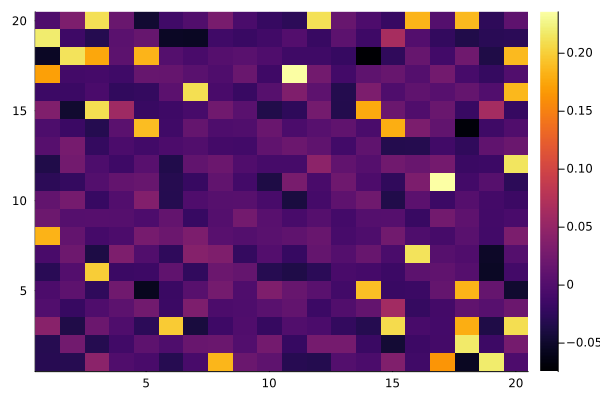

In [26]:
rec2 = query_edges(gvt1, nvt1, sa, tspan)
heatmap(rec2)

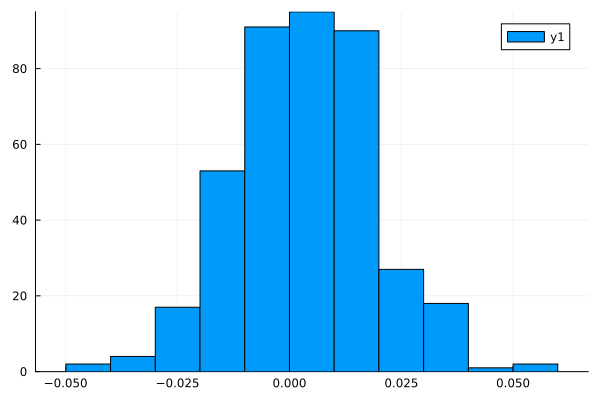

In [27]:
histogram((rec1 .- rec2)|> vec)

# Determine the quality of the reconstruction (AUROC)

In [28]:
function auroc(graph::AbstractMatrix, reconstruction::AbstractMatrix)
    tpr, fpr = tpr_fpr(vec(reconstruction), vec(graph))
    roc_fn = interpolate_roc((tpr, fpr))
    auc, err = quadgk(x -> roc_fn(x), 0.0, 1.0)
    return auc, err
end

auroc (generic function with 1 method)

In [29]:
auroc(g1, rec1)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


(1.0, 0.0)

In [30]:
auroc(g1, rec2)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


(1.0, 0.0)

In [31]:
auroc(g1, rand(rng, Float32, size(rec2)))

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.06793478260869565
│     0.16032608695652173
│     0.2391304347826087
│     0.32608695652173914
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


(0.575959582829452, 7.920927685728819e-9)

In [32]:
tpr, fpr = tpr_fpr(vec(rec1), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

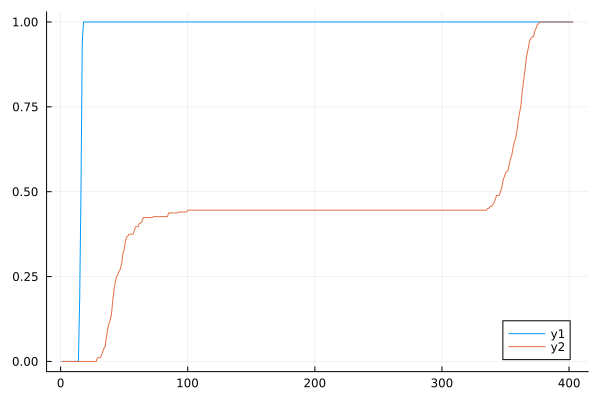

In [33]:
plot(tpr)
plot!(fpr)

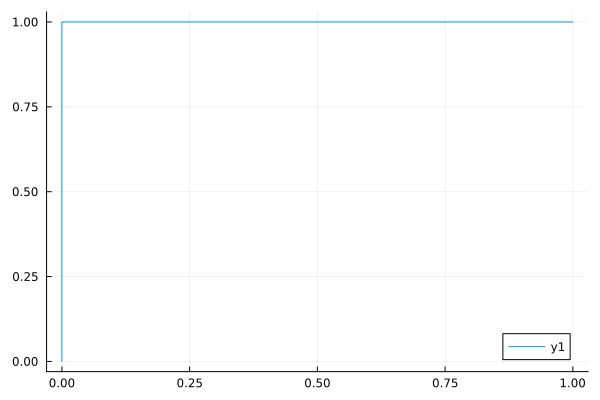

In [34]:
plot(fpr, tpr)

In [35]:
roc = interpolate_roc((tpr, fpr));

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


In [36]:
quadgk(x -> roc(x), 0.0, 1.0)

(1.0, 0.0)

In [37]:
tpr2, fpr2 = tpr_fpr(vec(rec2), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

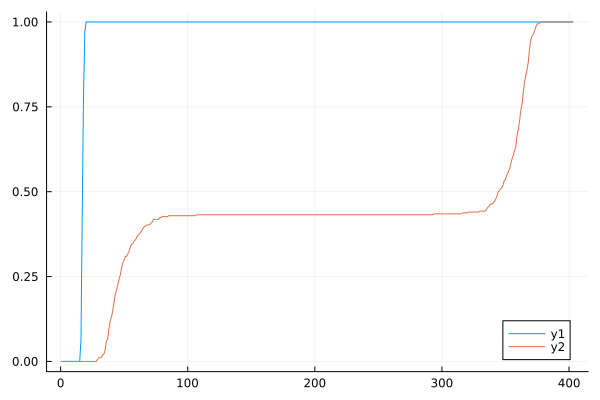

In [38]:
plot(tpr2)
plot!(fpr2)

In [39]:
quadgk(x -> interpolate_roc((tpr2, fpr2))(x), 0.0, 1.0)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


(1.0, 0.0)